In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Generate data 

In [12]:
n = 80#Number of observations in the training set

targetPrecision = 30

X = np.random.uniform(-np.pi, np.pi, n)
Y = [np.sin(x**2) - np.cos(x) + np.random.normal(0, np.sqrt(1/targetPrecision)) for x in X]

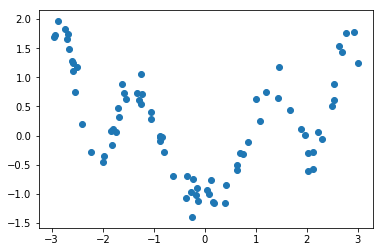

In [13]:
plt.scatter(X,Y)

# Let's sample over the prior distribution over functions to get a sense for what they look like

In [16]:
def kernelFunction(x1, x2, bandwidth):
    
    return np.exp(-(bandwidth/2)*(x1 - x2)**2)

def sampleFromPrior(numSamples = 25, bandwidth = 2, domain = [-1*np.pi, np.pi], step = 0.01):
    
        
    #Construct finite sample 'x'

    x = np.arange(domain[0], domain[1], step)

    #K will be the covariance matrix 
    K = []

    for j in x:
        K_j = []
        for jj in x:
            K_j.append(kernelFunction(j, jj, bandwidth))

        K.append(K_j)

    K = np.array(K)


    #Now sample from the multivariate normal
    Ys = np.random.multivariate_normal(mean = np.zeros(x.shape[0]), cov = K, size = numSamples)
    
    #Now plot the y's to get our plot 
    #Create figure
    fig = plt.figure(figsize = (10,6))

    for y in Ys:
        plt.plot(x, y, alpha = 0.3, figure=fig)
        
    return fig




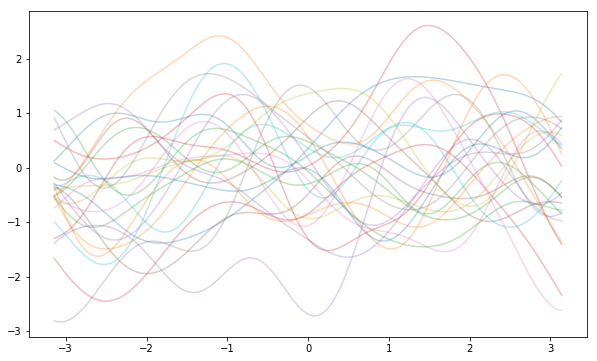

In [17]:
priorPlot = sampleFromPrior()

In [20]:
data = pd.DataFrame({'X':X, 'Y':Y})

In [32]:
class GaussianProcess:
    
    def __init__(self, data, target, features, targetPrecision, kernelBandwidth, trainTestRatio = 0.9):
        #data - a pandas dataset 
        #target - the name of the pandas column which contains the true labels
        #features - A list containing the names of the columns which we will use to do the regression
        #trainTestRatio - the proportion of the entire dataset which we'll use for training
                    #   - the rest will be used for testing
        
        self.target = target
        self.features = features 
        
        #Split up data into a training and testing set
        self.train, self.test = train_test_split(data, test_size=1-trainTestRatio)
    
        #Set precision (1/variance in the normal distribution) parameters
        #targetPrecision is a measure of the fluctuation in the target - for example if we had 
            #1000 examples with the exact same feature, how much variation would we see between the 
            #target variables - this value can be estimated from the data, but for simplicity here we
            #take the value we used when assigning noise when generating the data
        #kernelBandwidth quantifies how we weight different points in the training set depending on how far away they are
        
        self.targetPrecision = targetPrecision
        self.kernelBandwidth = kernelBandwidth
        
        self.X = self.train[self.features].to_numpy() #The training set, as a numpy array
        
    def kernel(self, xi, xj, kB = None):
        
        if kB is None:
            kB = self.kernelBandwidth
        
        return np.exp(-np.linalg.norm(xi - xj)/(2*kB))
    
    def calculateK(self):
        #K is the n x n Kernel matrix formed by calculating the pairwise distances between each two examples
        
        K = []
        
        for xi in self.X:
            for xii in self.X:
                K.append(self.kernel(xi, xii))

        self.K = np.array(K).reshape((self.X.shape[0], self.X.shape[0])) #save as an n x n matrix
    
    def calculateC(self):
        
        self.C = self.K + (1/self.targetPrecision)*np.identity(self.K.shape[0]) #Covariance matrix of the response
        
        
    
    def makePredictionWithVarianceSingle(self, x):
        #phi is the set of basis functions applied to a single input vector x
        
        c = self.kernel(x, x) + 1/self.targetPrecision
        k = np.array([self.kernel(x, xi) for xi in self.X])
        
        self.Cinv = np.linalg.inv(self.C)
        
        predMean = np.matmul(np.transpose(k), np.matmul(self.Cinv, self.train[self.target].to_numpy()))
        predVar = c - np.matmul(np.transpose(k), np.matmul(self.Cinv, k))
        
        
        
        return predMean, predVar
    
    def makePredictionsWithVariance(self, XNew):
        #Make predictions for a dataset of inputs
        #XNew is a pandas dataframe in the same form as the training set
        XNew = XNew.to_numpy()
        
        predMeans = []
        predVars = []
        
        for x in XNew:
            pm, pv = self.makePredictionWithVarianceSingle(x)
            
            predMeans.append(pm)
            predVars.append(pv)
        
        return predMeans, predVars
            

In [33]:
myGP = GaussianProcess(data, 'Y', ['X'], targetPrecision=targetPrecision, kernelBandwidth=1, trainTestRatio=0.8)

In [34]:
myGP.calculateK()
myGP.calculateC()

In [24]:
testMean, testVar = myGP.makePredictionsWithVariance(myGP.test[myGP.features])
myGP.test['predMean'] = np.array(testMean).reshape(-1)
myGP.test['predVar'] = np.array(testVar).reshape(-1)
myGP.test = myGP.test.sort_values(by = 'X', ascending = True)

/opt/anaconda3/envs/cgvae/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/cgvae/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


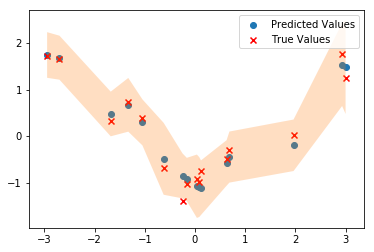

In [25]:
plt.scatter(myGP.test['X'], myGP.test['predMean'], label = 'Predicted Values')
plt.scatter(myGP.test['X'], myGP.test[[myGP.target]], marker = "x", color = 'red', label = 'True Values')
plt.fill_between(myGP.test['X'], myGP.test['predMean'] - 2*np.sqrt(myGP.test['predVar']), myGP.test['predMean'] + 2*np.sqrt(myGP.test['predVar']), alpha = 0.25)

plt.legend()
plt.show()

In [35]:
trainMean, trainVar = myGP.makePredictionsWithVariance(myGP.train[myGP.features])
myGP.train['predMean'] = np.array(trainMean).reshape(-1)
myGP.train['predVar'] = np.array(trainVar).reshape(-1)
myGP.train = myGP.train.sort_values(by = 'X', ascending = True)

/opt/anaconda3/envs/cgvae/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/cgvae/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


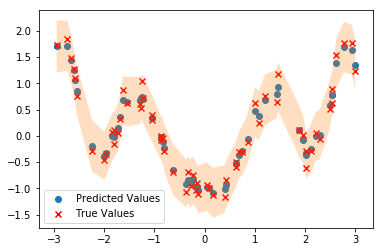

In [37]:
plt.scatter(myGP.train['X'], myGP.train['predMean'], label = 'Predicted Values')
plt.scatter(myGP.train['X'], myGP.train[[myGP.target]], marker = "x", color = 'red', label = 'True Values')
plt.fill_between(myGP.train['X'], myGP.train['predMean'] - 2*np.sqrt(myGP.train['predVar']), myGP.train['predMean'] + 2*np.sqrt(myGP.train['predVar']), alpha = 0.25)

plt.legend()
plt.show()

In [36]:
myGP.train

,X,Y,predMean,predVar
35,-2.946163,1.727541,1.700326,0.062103
48,-2.735271,1.835004,1.716913,0.056015
38,-2.657127,1.483297,1.450981,0.051791
4,-2.611089,1.277160,1.250737,0.049723
20,-2.573892,1.108453,1.059946,0.049202
...,...,...,...,...
13,2.536504,0.618885,0.785607,0.047222
19,2.623996,1.537730,1.378693,0.055412
77,2.774884,1.768151,1.687785,0.057561
32,2.929439,1.770347,1.641368,0.055402


In [26]:
myGP.test

,X,Y,predMean,predVar
35,-2.946163,1.727541,1.744466,0.060236
74,-2.700174,1.664972,1.686124,0.056021
64,-1.679226,0.322283,0.475230,0.057686
70,-1.329628,0.734913,0.672663,0.083477
60,-1.047903,0.398357,0.294561,0.061180
42,-0.624669,-0.692805,-0.489203,0.149497
47,-0.248614,-1.397897,-0.857321,0.058477
28,-0.163861,-1.021369,-0.933668,0.054165
62,0.037319,-0.925782,-1.079031,0.116136
46,0.084246,-0.994076,-1.097016,0.103608


# Now lets fit the model with a much smaller dataset and observe the effect on the variance

In [27]:
#Set train test split to be smaller so our training set is smaller
myBLRSmall = BayesianLinearRegression(data, 'Y', [f'X{i}' for i in range(5)], targetPrecision=targetPrecision, priorPrecision=1, trainTestRatio=0.3)
myBLRSmall.calculatePosterior()

NameError: name 'BayesianLinearRegression' is not defined

In [130]:
Xreg = np.arange(-np.pi, np.pi, step = 0.01)
#Get basis functions
phi = addBasisFunctions({}, Xreg, 5)

In [131]:
meanBig, varBig = myBLR.makePredictionsWithVariance(phi)
meanSmall, varSmall = myBLRSmall.makePredictionsWithVariance(phi)

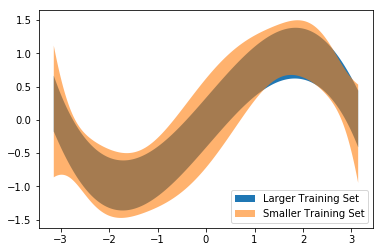

In [136]:
plt.fill_between(Xreg, meanBig - 2*np.sqrt(varBig), meanBig + 2*np.sqrt(varBig), alpha = 1, label = 'Larger Training Set')
plt.fill_between(Xreg, meanSmall - 2*np.sqrt(varSmall), meanSmall + 2*np.sqrt(varSmall), alpha = 0.6, label = 'Smaller Training Set')

plt.legend(loc = 4)
plt.show()

We can see that the variance in the model trained with the smaller training set provides greater uncertainty in its predictions. The smaller the coloured region, the greater the confidence we have in our predictions.

# Visualising the distributions over functions

Lots of the literature surrounding Bayesian regression talks about a distribution *over functions*. This can be very difficult for us to understand as we're used to thinking about distributions over continuous (e.g. the normal distribution) or discrete (e.g. the binomial distribution) sets of numbers.

When we specify our prior distribution over the weights of a model, which we need to do to fit the Bayesian linear regression model, we're specifying a multivariate normal distribution. Under this set-up, each possible combination of weights comes with an associated probability. Consider the following example: If we're trying to fit a model of the form $y = w_0 + w_1 \times x$ (and therefore trying to find the optimal set of weights $(w_0, w_1)$), and we specify a prior for $$\begin{pmatrix} w_0 \\ w_1 \end{pmatrix} \sim N \Bigg(\begin{pmatrix} 0 \\ 0 \end{pmatrix} , \begin{pmatrix} \alpha_1 & 0 \\ 0 & \alpha_2 \end{pmatrix} \Bigg)$$

Under this prior distribution, we can verify that the pair of weights $(1,2)$ is more likely than the pair of weights $(75, 100)$ - this is because the closer a pair of weights is to the mean of our prior distribution, the more likely it is.

But under the model assumption that we made, a pair of weights uniquely corresponds to a function - we can therefore say that the function $y = 1 + 2 \times x$ is more likely than $y = 75 + 100 \times x$, because both of these functions corresponds uniquely to a pair of weights and we have a well-defined distribution which tells us how likely a pair of weights is.

This weights-to-function relationship allows us to think about a distribution over functions. As we fit the Bayesian regression model, we obtain a posterior distribution over the weights and therefore a new distribution over functions too.

To gain some intuition for these distributions, lets sample some functions from them and plot them

## Sampling from the prior distribution

For the models we've fit above, the prior weights distribution we specified was: $w \sim N(0, I_5)$, lets sample 50 sets of weights from that distribution:

In [138]:
priorWeights = np.random.multivariate_normal(mean = np.zeros(5), cov = np.identity(5), size = 50)

In [186]:
#Convert weights to functions
priorFunctions = []
for w in priorWeights:
    priorFunctions.append(np.dot(w, np.transpose(phi.to_numpy())))
    
priorFunctions = np.array(priorFunctions)

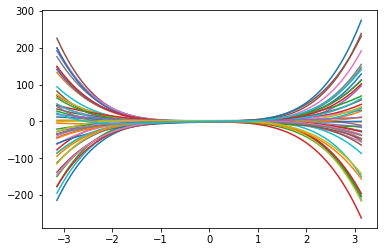

In [158]:
for f in priorFunctions:
    plt.plot(Xreg, f)


We can see that the functions sampled from the prior don't fit the dataset we're trying to fit our model to at all - that's ok! There's no real reason we'd expect it to, since we selected a 'non-informative' prior

## Sampling from the posterior distribution 

In [159]:
posteriorWeights = np.random.multivariate_normal(mean = myBLR.postMean, cov = myBLR.postVar, size = 50)

In [160]:
postFunctions = []
for w in posteriorWeights:
    postFunctions.append(np.dot(w, np.transpose(phi.to_numpy())))
    
postFunctions = np.array(postFunctions)

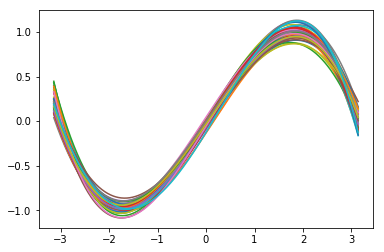

In [161]:
for f in postFunctions:
    plt.plot(Xreg, f)

These functions, sampled from our posterior distribution on functions, much more closely resembles the dataset. In fact, with all the functions laid on top of each other, the area they occupy resembles the confidence interval we plotted above. This is not a coincidence, at each point on the x axis the 95% confidence interval we plotted is a region such that if we sampled a random function from the posterior, then 95% of the time, that function would be within the confidence interval at a specific x-value

## To get an intermediate view on the distribution over functions, let's fit a model with only a handful of datapoints and see what the distribution looks like there

In [166]:
#Set train test split to be smaller so our training set is smaller
myBLRReallySmall = BayesianLinearRegression(data, 'Y', [f'X{i}' for i in range(5)], targetPrecision=targetPrecision, priorPrecision=1, trainTestRatio=0.15)
myBLRReallySmall.calculatePosterior()

In [167]:
posteriorWeightsSmall = np.random.multivariate_normal(mean = myBLRReallySmall.postMean, cov = myBLRReallySmall.postVar, size = 50)

In [168]:
postFunctionsSmall = []
for w in posteriorWeightsSmall:
    postFunctionsSmall.append(np.dot(w, np.transpose(phi.to_numpy())))
    
postFunctionsSmall = np.array(postFunctionsSmall)

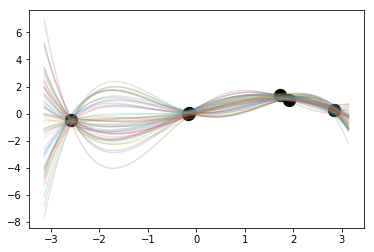

In [183]:
plt.scatter(myBLRReallySmall.train['X1'], myBLRReallySmall.train['Y'], color = 'black', s = 150)

for f in postFunctionsSmall:
    plt.plot(Xreg, f, alpha = 0.2)
    
plt.show()

All of the functions predict similar values around the points where we have training data (the black dots), but as we move further away from those points, the uncertainty begins to increase and the functions sampled from the posterior begin to diverge away from each other. This is very desirable behaviour when fitting a Bayesian model, as it allows us to say clearly whether we're confident in our predictions or not and allows us to give bounds on what we think the target variable is likely to be.